In [ ]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

In [1]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from enum import Enum
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\berna\anaconda3\envs\nli_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [3]:
def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Loop through each turn in the dialogue
        for i in range(num_turns):

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Append as a dictionary to the data list
            data.append({'Utterance': utterance, 'DialogueAct': dialogue_act})

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['Utterance']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data)
X_val, Y_val = toDataFrame(val_data)
X_test, Y_test = toDataFrame(test_data)

# Final Training
X_test_val = pd.concat([X_test,X_val])
Y_test_val = pd.concat([Y_test, Y_val])

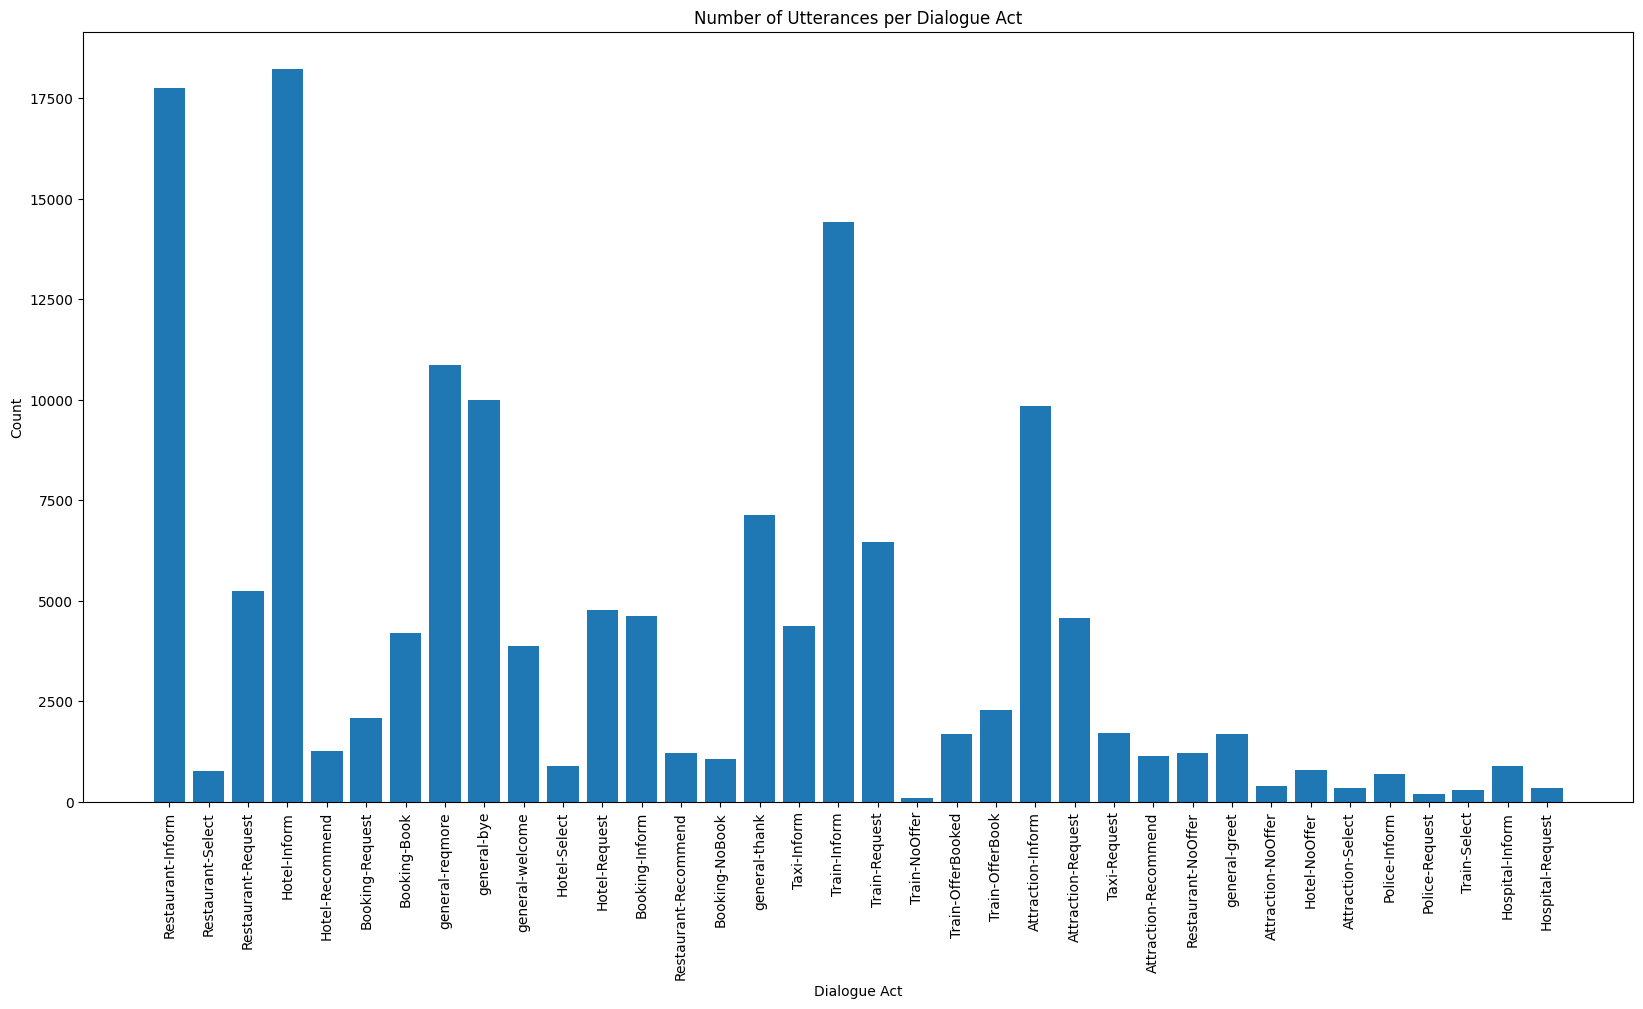

[('Train-NoOffer', 102), ('Police-Request', 196), ('Train-Select', 307), ('Attraction-Select', 348), ('Hospital-Request', 355), ('Attraction-NoOffer', 398), ('Police-Inform', 696), ('Restaurant-Select', 781), ('Hotel-NoOffer', 804), ('Hotel-Select', 887)]


In [4]:
# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance. 
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])


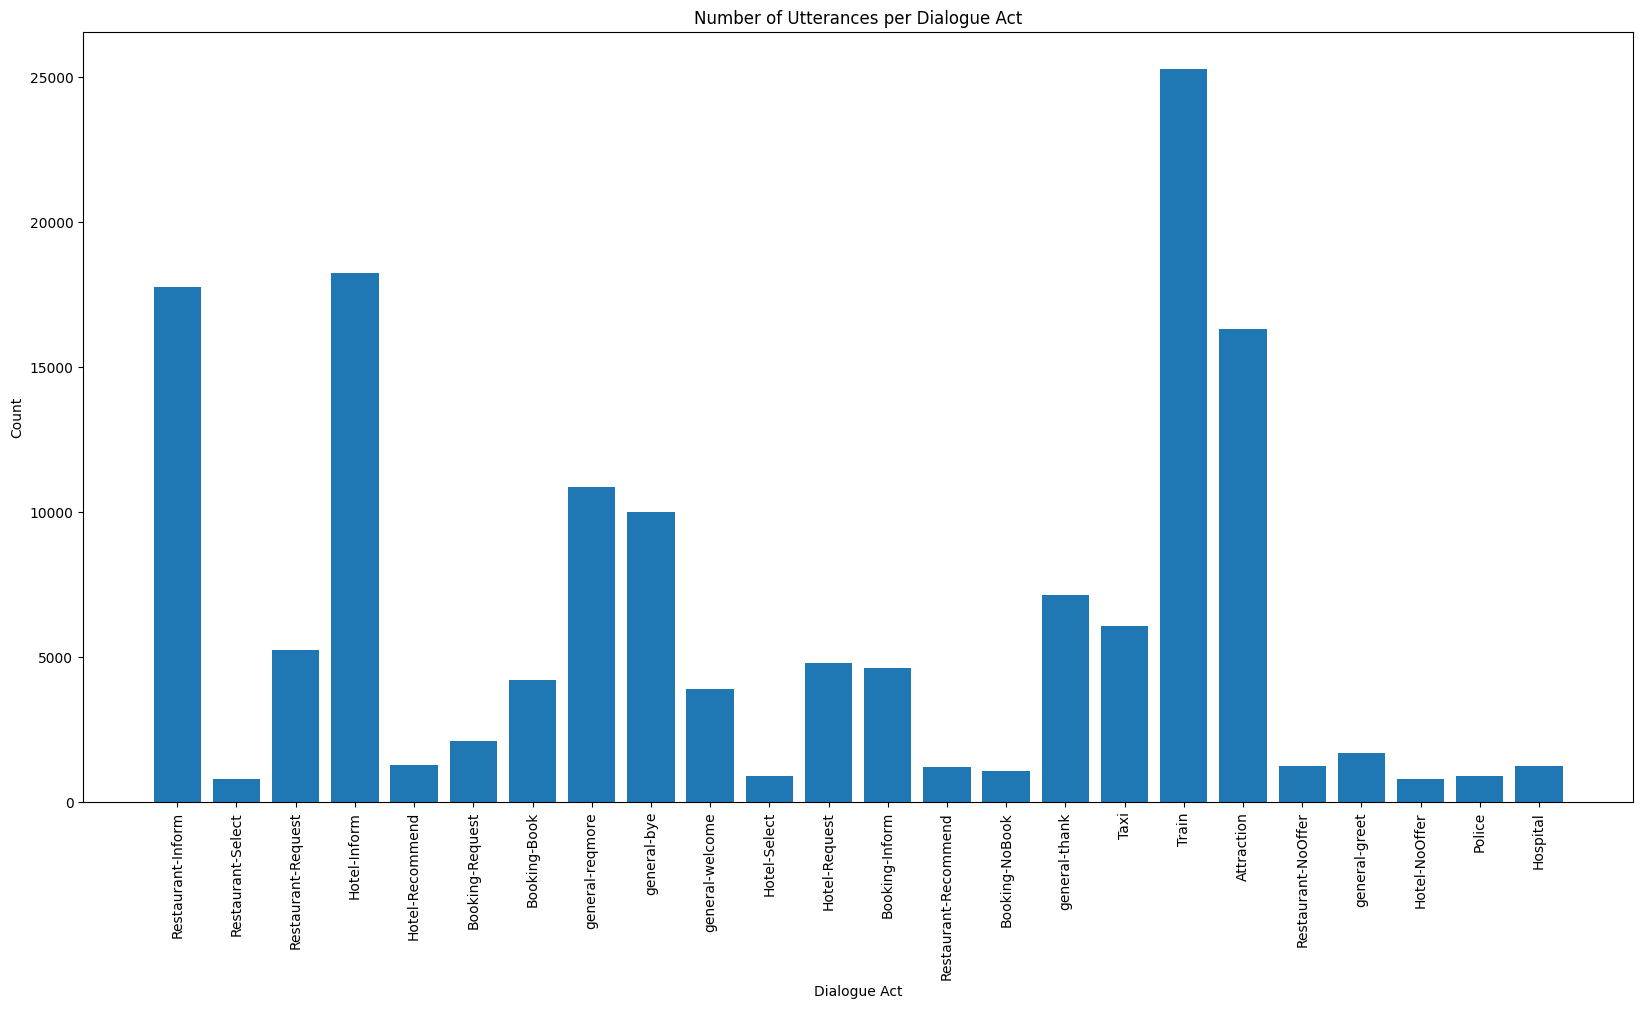

In [5]:
# For every utterance, change the label of the dialogue act which has the following structure: domain-act to domain if the domain is not
# one of the [Restaurant, Hotel, Booking, General]
def relabel_data(Y):
    """
    For every utterance, change the label of the dialogue act which has the following structure: domain-act to domain if the domain is not
    one of the [Restaurant, Hotel, Booking, General]

    Parameters:
    - Y: list of lists of dialogue acts.

    Returns:
    - Relabelled list of lists of dialogue acts.
    """
    # Initialize an empty list to store the relabelled data
    Y_relabelled = []

    # Loop through each dialogue act array in the data
    for dialogue_act_array in Y:

        # Initialize an empty list to store the relabelled dialogue acts for this utterance
        relabelled_dialogue_act_array = []

        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:

            # If the dialogue act is not one of the [Restaurant, Hotel, Booking, General], change the label to domain
            if dialogue_act.split('-')[0].upper() not in ['RESTAURANT', 'HOTEL', 'BOOKING', 'GENERAL']:
                relabelled_dialogue_act_array.append(dialogue_act.split('-')[0])
            
            # If the dialogue act is one of the [Restaurant, Hotel, Booking, General], keep the label as is
            else:
                relabelled_dialogue_act_array.append(dialogue_act)

        # Append the relabelled dialogue act array to the relabelled data
        Y_relabelled.append(relabelled_dialogue_act_array)
    
    return Y_relabelled

def prune_empty_dialogue_acts(X, Y):
    """
    Prunes the data to exclude utterances with no dialogue acts.

    Parameters:
    - X: list of utterances.
    - Y: list of lists of dialogue acts.

    Returns:
    - relabelled lists of utterances and dialogue acts.
    """
    # Initialize empty lists to store the pruned data
    X_pruned = []
    Y_pruned = []

    # Loop through each utterance and corresponding dialogue act array in the data
    for utterance, dialogue_act_array in zip(X, Y):

        # If the dialogue act array is not empty, append the utterance and dialogue act array to the pruned data
        if len(dialogue_act_array) > 0:
            X_pruned.append(utterance)
            Y_pruned.append(dialogue_act_array)
    
    return X_pruned, Y_pruned


# Prune the training, validation, and test data
Y_relabelled_train = relabel_data(Y_train)
Y_relabelled_val = relabel_data(Y_val)
Y_relabelled_test = relabel_data(Y_test)
Y_relabelled_test_val = relabel_data(Y_test_val)

# Prune empty dialogue acts for training, validation, and test data
X_pruned_train, Y_pruned_train = prune_empty_dialogue_acts(X_train, Y_relabelled_train)
X_pruned_val, Y_pruned_val = prune_empty_dialogue_acts(X_val, Y_relabelled_val)
X_pruned_test, Y_pruned_test = prune_empty_dialogue_acts(X_test, Y_relabelled_test)
X_pruned_test_val, Y_pruned_test_val = prune_empty_dialogue_acts(X_test_val, Y_relabelled_test_val)

# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance.
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_pruned_train:
    # Loop through each dialogue act in the dialogue act array
    for dialogue_act in dialogue_act_array:
        
        # If the dialogue act is already in the dictionary, increment its count by 1
        if dialogue_act in counts:
            counts[dialogue_act] += 1
        
        # If the dialogue act is not already in the dictionary, set its count to 1
        else:
            counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object on the training data
mlb.fit(Y_pruned_train)

# Transform the training, validation, and test data
Y_encoded_train = mlb.transform(Y_pruned_train)
Y_encoded_val = mlb.transform(Y_pruned_val)
Y_encoded_test = mlb.transform(Y_pruned_test)
Y_encoded_test_val = mlb.transform(Y_pruned_test_val)

# Print the shape of the encoded training, validation, and test data
print(Y_encoded_train.shape)
print(Y_encoded_val.shape)
print(Y_encoded_test.shape)
print(Y_encoded_test_val.shape)

# Print the classes
print(mlb.classes_)
# Print the number of classes
print(len(mlb.classes_))

# Print the first 10 encoded training labels
print(Y_encoded_train[:10])

# Print the first 10 decoded training labels
print(mlb.inverse_transform(Y_encoded_train[:10]))

# Dump the MultiLabelBinarizer object to a pickle file
import pickle
pickle.dump(mlb, open('mlb.pkl', 'wb'))

(112392, 24)
(14594, 24)
(14613, 24)
(29207, 24)
['Attraction' 'Booking-Book' 'Booking-Inform' 'Booking-NoBook'
 'Booking-Request' 'Hospital' 'Hotel-Inform' 'Hotel-NoOffer'
 'Hotel-Recommend' 'Hotel-Request' 'Hotel-Select' 'Police'
 'Restaurant-Inform' 'Restaurant-NoOffer' 'Restaurant-Recommend'
 'Restaurant-Request' 'Restaurant-Select' 'Taxi' 'Train' 'general-bye'
 'general-greet' 'general-reqmore' 'general-thank' 'general-welcome']
24
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
[('Restaurant-Inform',), ('Restaurant-Inform', '

In [ ]:
# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        encoded = tokenizer.encode_plus(
            x, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(y)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_pruned_train, Y_encoded_train)
val_input, val_masks, val_labels = tokenize_data(X_pruned_val, Y_encoded_val)
test_input, test_masks, test_labels = tokenize_data(X_pruned_test, Y_encoded_test)
test_val_input, test_val_masks, test_val_labels = tokenize_data(X_pruned_test_val, Y_encoded_test_val)

In [ ]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 4 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)
test_val_data = TensorDataset(test_val_input, test_val_masks, test_val_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
test_val_loader = DataLoader(test_val_data, batch_size=batch_size, num_workers=num_workers)

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = torch.sigmoid(self.fc(cls_output))
        return logits

In [ ]:
class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [ ]:
# model = BertClassifier()
# model = model.to(device)
 
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.BCELoss()

# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# save_best_model_instance = SaveModelWithBestValLoss()

# # For storing training and validation loss
# train_losses = []
# val_losses = []

# lrs = []
# for epoch in range(40):
#     model.train()
    
#     # Initialize tqdm progress bar
#     #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
#     train_loss = 0.0
#     for batch in train_loader:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         logits = model(input_ids, attention_mask)
#         loss = criterion(logits, labels.float())
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         lrs.append(optimizer.param_groups[0]["lr"])
#         scheduler.step()
        
#         # Update training loss
#         train_loss += loss.item()
#         #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
#     # Average training loss
#     avg_train_loss = train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # Validation
#     val_loss = 0.0
#     model.eval()

#     # Initialize tqdm progress bar for validation
#     #val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = batch
#             input_ids = input_ids.to(device)
#             attention_mask = attention_mask.to(device)
#             labels = labels.to(device)

            
#             # Forward pass
#             logits = model(input_ids, attention_mask)
#             loss = criterion(logits, labels.float())
            
#             val_loss += loss.item()
#             #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
#     # Average validation loss
#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)
#     if len(val_losses) >= 4:
#         diff_val_loss_1 = val_losses[-2] - val_losses[-1]
#         diff_val_loss_2 = val_losses[-3] - val_losses[-1]
#         diff_val_loss_3 = val_losses[-4] - val_losses[-1]
#         if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
#             print(f'Epoch {epoch}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
#             break
    
#     print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
#     # Save model if validation model loss decreases
#     save_best_model_instance.save(
#         avg_val_loss, epoch, model, optimizer, criterion
#     )

In [ ]:
# # Plotting validation and training loss
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# # build the model, without loading the pre-trained weights or fine-tune layers
# saved_model = BertClassifier().to(device)
# best_model = torch.load('best_model.pth')
# saved_model.load_state_dict(best_model['model_state_dict'])

In [ ]:
# all_preds = []
# all_labels = []

# # Put the Saved Model in evaluation mode
# saved_model.eval()

# # Disable gradient computation
# with torch.no_grad():
#     # Initialize tqdm progress bar for Test
#     test_bar = tqdm(test_loader, desc='Test')

#     for batch in test_bar:
#         input_ids, attention_mask, labels = batch
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         logits = saved_model(input_ids, attention_mask)

#         # Get the predicted labels
#         #_, preds = torch.max(logits, dim=1)

#         # Move preds and labels to CPU for further evaluation (if using GPU)
#         preds = logits.cpu().numpy()
#         labels = labels.cpu().numpy()

#         # Extend the list of predictions and labels
#         all_preds.extend(preds)
#         all_labels.extend(labels)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
# import numpy as np
# threshold = 0.5
# all_preds_binary = []
# for all_pred in all_preds:
#     local_pred = []
#     for old_local_pred in all_pred:
#         binary_local_pred = (old_local_pred > threshold).astype(int)
#         local_pred.append(binary_local_pred)
#     all_preds_binary.append(local_pred)

# confusion_matrices = mcm(all_labels, all_preds_binary)
# print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# # Plotting
# n_labels = confusion_matrices.shape[0]
# fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

# for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
#     im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     ax.figure.colorbar(im, ax=ax)
#     ax.set(title=mlb.classes_[i], 
#            ylabel='True label',
#            xlabel='Predicted label',
#            xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=['0', '1'], yticklabels=['0', '1'])

# plt.tight_layout()
# plt.show()

In [ ]:
# Final Model
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(45):
    model.train()
    
    # Initialize tqdm progress bar
    #train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        #train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    #val_bar = tqdm(test_val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in test_val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            #val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    
    print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

In [ ]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_val_loader, desc='Test')

    for batch in test_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import numpy as np
threshold = 0.5
all_preds_binary = []
for all_pred in all_preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)

confusion_matrices = mcm(all_labels, all_preds_binary)
print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# Plotting
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=mlb.classes_[i], 
           ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.tight_layout()
plt.show()

In [ ]:
def predict(model, sentence, tokenizer):
    model.eval()
    
    encoded = tokenizer.encode_plus(
        sentence, 
        add_special_tokens=True, 
        max_length=256, 
        padding='max_length', 
        truncation=True, 
        return_attention_mask=True)
    
    input_ids = torch.tensor([encoded['input_ids']], dtype=torch.long).to(device)
    attention_mask = torch.tensor([encoded['attention_mask']], dtype=torch.long).to(device)
    
    # Make a prediction
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    
    logits_cpu = logits.to('cpu')
    return logits_cpu.numpy()


sentence = "I would like to make a reservation for a table on October 12th."
preds = predict(saved_model, sentence, tokenizer)
threshold = 0.5
all_preds_binary = []
for all_pred in preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)
labels_preds = mlb.inverse_transform(np.array(all_preds_binary))
print("Predicted label:", labels_preds)
